# Kratos example: linear model

In [15]:
from probabilistic_library import ReliabilityProject, ReliabilityMethod, DistributionType, CombineProject, CombineType, CombinerMethod, CompareType
from probabilistic_library import UncertaintyProject, UncertaintyMethod, Stochast

### Model

In [16]:
from run_kratos_quay_wall import zfuncwrapper_linear

### Variables

In [17]:
def define_project_variables(project):

    project.variables["geo_young_modulus"].is_array = True
    project.variables["geo_young_modulus"].array_size = 7
    for i in range(project.variables["geo_young_modulus"].array_size):
        if i in [0, 1, 2, 3, 4]: # Clays with low-medium plasticity, medium
            young_modulus = Stochast()
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 5*10**6
            young_modulus.maximum = 8*10**6
        elif i in [5, 6]: # Sand, uniform, medium
            young_modulus = Stochast()
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 30*10**6
            young_modulus.maximum = 50*10**6
        project.variables["geo_young_modulus"].array_variables.append(young_modulus)

    project.variables["sheetpile_young_modulus"].distribution = DistributionType.deterministic
    project.variables["sheetpile_young_modulus"].is_array = True
    project.variables["sheetpile_young_modulus"].array_size = 1
    project.variables["sheetpile_young_modulus"].mean = 200e9 # value checked

    project.variables["sheetpile_poisson_ratio"].distribution = DistributionType.deterministic
    project.variables["sheetpile_poisson_ratio"].is_array = True
    project.variables["sheetpile_poisson_ratio"].array_size = 1
    project.variables["sheetpile_poisson_ratio"].mean = 0.0 # value checked

    project.variables["sheetpile_thickness"].distribution = DistributionType.deterministic
    project.variables["sheetpile_thickness"].is_array = True
    project.variables["sheetpile_thickness"].array_size = 1
    project.variables["sheetpile_thickness"].mean = 0.02159 # value checked

    return project

### Uncertainty analysis (max x-displacement)

In [18]:
project = UncertaintyProject()
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.max_x_displacement

project.model.print()

Model max_x_displacement:
Input parameters:
  geo_young_modulus[1]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  np.abs(max_x_displacement)


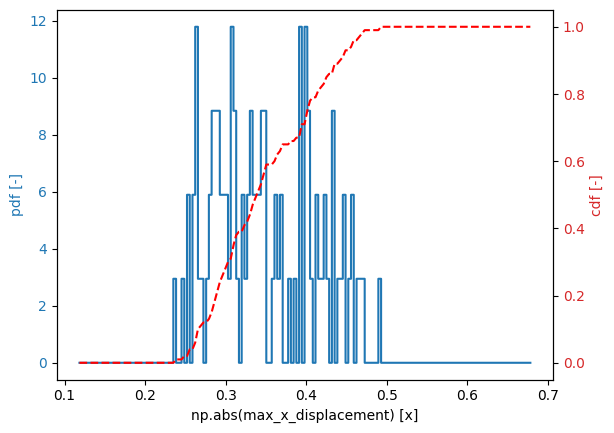

In [19]:
project = define_project_variables(project)

project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.stochast.plot()

### Uncertainty analysis (max bending moment)

In [20]:
project = UncertaintyProject()
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.max_bending_moment

project.model.print()

Model max_bending_moment:
Input parameters:
  geo_young_modulus[1]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  max_bending_moment


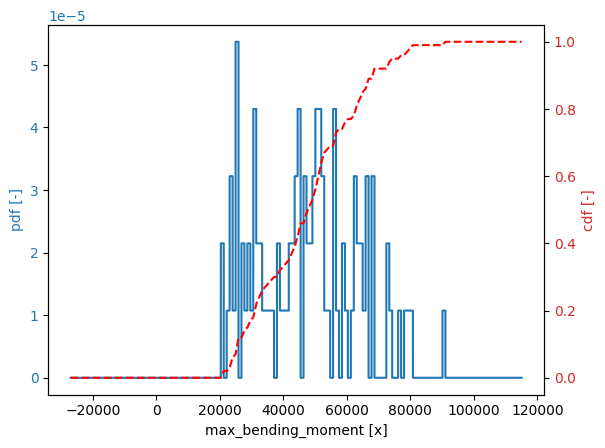

In [21]:
project = define_project_variables(project)

project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.stochast.plot()

### Reliability analysis (max x-displacement)

In [22]:
project = ReliabilityProject()
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.max_x_displacement

project.model.print()

Model max_x_displacement:
Input parameters:
  geo_young_modulus[1]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  np.abs(max_x_displacement)


In [23]:
project = define_project_variables(project)

project.settings.reliability_method = ReliabilityMethod.form
project.settings.variation_coefficient = 0.02
project.settings.maximum_iterations = 50
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.critical_value = 0.35

project.run()

project.design_point.print()

dp1 = project.design_point

Reliability (FORM)
 Reliability index = 0.02403
 Probability of failure = 0.4904
 Convergence = 0.005568 (converged)
 Model runs = 40
Alpha values:
 geo_young_modulus[0]: alpha = -0.02828, x = 6.501e+06
 geo_young_modulus[1]: alpha = 0.01763, x = 6.499e+06
 geo_young_modulus[2]: alpha = -0.3372, x = 6.51e+06
 geo_young_modulus[3]: alpha = 0.1621, x = 6.495e+06
 geo_young_modulus[4]: alpha = 0.9205, x = 6.474e+06
 geo_young_modulus[5]: alpha = -0.1076, x = 4.002e+07
 geo_young_modulus[6]: alpha = 0.001184, x = 4e+07
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159



### Reliability analysis (max bending moment)

In [24]:
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.max_bending_moment

project.model.print()

project.settings.reliability_method = ReliabilityMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.critical_value = 40000

project.run()

project.design_point.print()

dp2 = project.design_point

Model max_bending_moment:
Input parameters:
  geo_young_modulus[7]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  max_bending_moment
Reliability:
 Reliability index = -0.4399
 Probability of failure = 0.67
 Convergence = 0.1425 (not converged)
 Model runs = 100
Alpha values:
 geo_young_modulus[0]: alpha = -0.2122, x = 6.388e+06
 geo_young_modulus[1]: alpha = 0.06772, x = 6.536e+06
 geo_young_modulus[2]: alpha = 0.5684, x = 6.796e+06
 geo_young_modulus[3]: alpha = -0.7586, x = 6.108e+06
 geo_young_modulus[4]: alpha = -0.1792, x = 6.406e+06
 geo_young_modulus[5]: alpha = 0.1369, x = 4.048e+07
 geo_young_modulus[6]: alpha = -0.02966, x = 3.99e+07
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159



### Combine probabilities

In [25]:
combine_project = CombineProject()

combine_project.design_points.append(dp1)
combine_project.design_points.append(dp2)

combine_project.settings.combine_type = CombineType.series
combine_project.settings.combiner_method = CombinerMethod.hohenbichler_form

combine_project.run()

combine_project.design_point.print()

Reliability:
 Reliability index = -1.244
 Probability of failure = 0.8933
 Model runs = 0
Alpha values:
 geo_young_modulus[0]: alpha = -0.2558, x = 6.125e+06
 geo_young_modulus[1]: alpha = 0.08845, x = 6.631e+06
 geo_young_modulus[2]: alpha = 0.3311, x = 6.979e+06
 geo_young_modulus[3]: alpha = -0.6891, x = 5.587e+06
 geo_young_modulus[4]: alpha = 0.5814, x = 7.296e+06
 geo_young_modulus[5]: alpha = 0.05727, x = 4.057e+07
 geo_young_modulus[6]: alpha = -0.03152, x = 3.969e+07
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159

